In [2]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy
from scipy.special import expit
import pytensor.tensor as pt

## Multilevel Adventures 

**Clusters**: Kinds of groups in the data

**Features**: Aspects of the model (parameters) that vary by cluster 

        Cluster -> Features
          tanks -> survival
        stories -> treatment effect
    individuals -> average response
    departments -> admission rate, bias
    
**Add clusters**: More index variables, more population priors

**Add features**: More parameters, more dimensions in each population prior

## Varying effectss as confounds

**Varying effect strategy**: Unmeasured features of clusters leave an imprint on the data that can be measured by 1) repeat observations of each cluster and 2) partial pooling 

**Predictive Perspective**: Important source of cluster-level variation, regularize

**Causal Perspective**: Competing causes or unobserved confounds

e.g. Grandparents influence on nparents and children, Neighborhood haunting. 

Trolley responses, Individuals add a lot of individuality and also effect Participation. 

Advantage over "fixed effect" approach: Can include other cluster level (time invariant) causes

**Fixed effects**: Varying effects with variance fixed at infinity, no pooling

Don't panic: Make a generative model and draw the owl


## Practical Difficulties

Varying effects are a good default, but ....

1) How to use more than one cluster type at theh same time?

2) How to calculate predictions? Are you making predictions for whole new clusters? Or new elements inside of previously experienced clusters? 

3) How to sample chains efficiently

4) Group-level confounding

## Fertility & behavior

1989 Bangladesh Fertility Survey

data(bangladesh)

1934 women, 61 districts

Outcome: contraceptive use

age,living children, urban/rural

Descriptively: Need to understand what is happening

Causally: Want to understand why

## Varying districts

Estimand: C in each district, partially pooled

Varying intercept on each district

Another chance to understand partial pooling 

In [4]:
bang = pd.read_csv('Data/bangladesh.csv',sep=';')
bang.head()

,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


C ~ Bernoulli(p) Bernoulli because 0/1 outcome

logit(p) = aD[i] log-odds of C=1 in each district D

aj ~ Normal(abar,sigma) Regularizing prior for districts

abar ~ Normal(0,1) Average district

sigma ~ Exponential(1) Standard deviation among districts 

In [11]:
np.unique(bang['district'].values).shape[0]

60

In [41]:
np.ptp(bang['district'])

60

In [40]:
np.unique(bang['district'].values -1).shape[0]

60

In [30]:
np.unique(bang['district'].values)[59]

61

In [44]:
with pm.Model() as bangvi_m: #Simply varying intercepts model
    
    C = pm.MutableData('C',bang['use.contraception'].values)
    D = pm.MutableData('D',bang['district'].values -1)
    
    sigma = pm.Exponential('sigma',1)
    abar  = pm.Normal('abar',0,1)
    a    = pm.Normal('a',abar,sigma,shape = 61) #61 districts, not all in sample
    
    Cobs = pm.Bernoulli('Cobs',logit_p = a[D],observed = C)
    
    bangvi_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, abar, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


In [46]:
az.summary(bangvi_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
abar,-0.536,0.087,-0.695,-0.369,0.002,0.001,2735.0,2964.0,1.0
a[0],-0.991,0.197,-1.347,-0.603,0.003,0.002,5246.0,2446.0,1.0
a[1],-0.591,0.352,-1.237,0.073,0.005,0.004,4956.0,3083.0,1.0
a[2],-0.221,0.497,-1.140,0.742,0.008,0.007,4101.0,2540.0,1.0
a[3],-0.183,0.304,-0.737,0.379,0.005,0.004,4116.0,3121.0,1.0
...,...,...,...,...,...,...,...,...,...
a[57],-0.299,0.298,-0.855,0.271,0.004,0.003,6017.0,3241.0,1.0
a[58],-1.010,0.435,-1.800,-0.156,0.007,0.005,4100.0,2570.0,1.0
a[59],-0.993,0.320,-1.594,-0.404,0.005,0.004,4766.0,3307.0,1.0
a[60],-1.056,0.309,-1.620,-0.450,0.005,0.004,3909.0,2526.0,1.0


<AxesSubplot: >

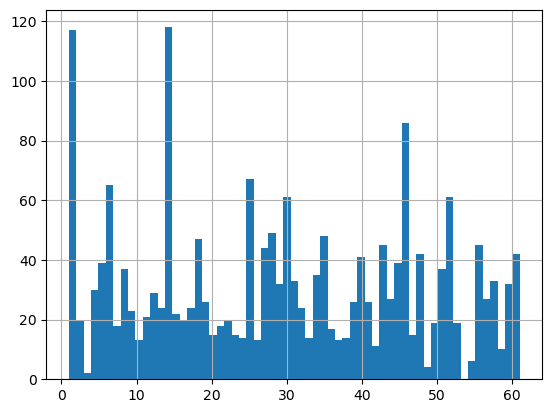

In [48]:
bang['district'].hist(bins=61)

#Much more evidence for some districts 

In [49]:
bang.head()

,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


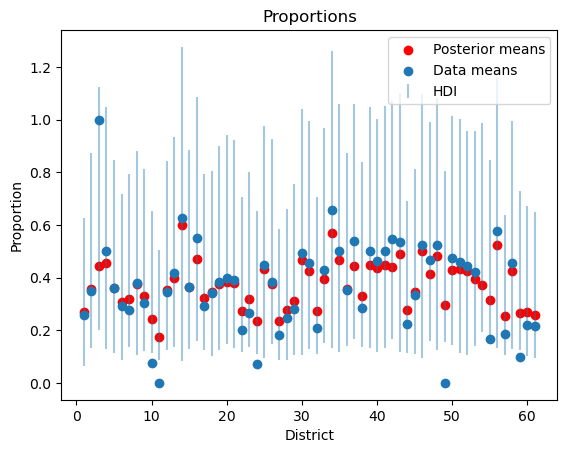

In [80]:
plt.scatter(x=bangvi_trace.posterior.a_dim_0 + 1 ,
            y= expit(bangvi_trace.posterior.a.mean(('chain','draw'))),
            c='r',label='Posterior means'
           )
plt.errorbar(x=bangvi_trace.posterior.a_dim_0 + 1 ,
             y= expit(bangvi_trace.posterior.a.mean(('chain','draw'))),
             yerr=np.swapaxes(expit(az.hdi(bangvi_trace.posterior.a)).a,0,1), 
             alpha=0.4,
             fmt='none',
             label='HDI'
            )

plt.scatter(x=bang['district'].unique(), 
            y = bang.groupby('district')['use.contraception'].mean(),
            label='Data means')
plt.title('Proportions')


plt.xlabel('District')
plt.ylabel('Proportion')
plt.legend()

#Districts with less data get pooled more! 
#1 district has no observations, but the model makes an estimate nonetheless

## Varying Districts

Partial pooling shrinks districts with low sampling towards mean

Better predictions

No inference yet 

We don't want/expect the model to recapitulate the sample, there are features of the sample that are not regular and we are trying to regularize

## Varying districts + urban

What is the effect of urban living?

District features are potential group-level confounds

Total effect of U passes through K

Do not stratify by K!

C ~ Bernoulli(p) Bernoulli because 0/1 outcome

logit(p) = aD[i] +BdiUi log-odds of C=1 in each district D, Ui is urban indicator

aj ~ Normal(abar,sigma) Regularizing prior for rural

bj ~ Normal(bbar,tau) effect of urban living, varies by district

abar ~ Normal(0,1) Average district

bbar ~ Normal(0,1)

sigma ~ Exponential(1) Standard deviation among districts 

tau ~ Exponential(1)

In [82]:
with pm.Model() as bangu_m: #Simply varying intercepts model
    
    C = pm.MutableData('C',bang['use.contraception'].values)
    D = pm.MutableData('D',bang['district'].values -1)
    U = pm.MutableData('U',bang['urban'])
    
    sigma = pm.Exponential('sigma',1)
    tau   = pm.Exponential('tau',1)
    
    abar  = pm.Normal('abar',0,1)
    bbar  = pm.Normal('bbar',0,1)
    
    a     = pm.Normal('a',abar,sigma,shape = 61) #61 districts, not all in sample
    b     = pm.Normal('b',bbar,tau,shape = 61)
    
    logit_p = a[D] +b[D]*U
    Cobs = pm.Bernoulli('Cobs',logit_p = logit_p,observed = C)
    
    bangu_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, abar, bbar, a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


In [83]:
az.summary(bangu_trace,var_names=['bbar','abar','tau','sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bbar,0.611,0.160,0.308,0.916,0.005,0.003,1084.0,1031.0,1.00
abar,-0.695,0.092,-0.861,-0.519,0.003,0.002,828.0,792.0,1.01
tau,0.569,0.191,0.166,0.885,0.017,0.012,120.0,72.0,1.03
sigma,0.484,0.090,0.316,0.651,0.004,0.003,452.0,1087.0,1.01


## More priors, more problems

Priors inside of priors: **"centered"** 

Challenging to sample for HMC 

Can rexpress WITHOUT centering

z = (a-abar)/sigma

a = abar+z*sigma 

z[a,j] ~ Normal(0,1)

## Non-centered varying intercepts

C ~ Bernoulli(p) Bernoulli because 0/1 outcome

logit(p) = aD[i] +BdiUi log-odds of C=1 in each district D, Ui is urban indicator

aj = abar +z[a,j] * sigma Noncentering a

bj = bbar +z[b,j] * tau noncentering b

z[a,j] ~ Normal(0,1)
Z[b,j] ~ Normal(0,1)
abar ~ Normal(0,1) Average district

bbar ~ Normal(0,1)

sigma ~ Exponential(1) Standard deviation among districts 

tau ~ Exponential(1)

### Mathematically equivalent to previous, but more efficient! ##

In [91]:
with pm.Model() as bangunc_m: #Non centered varying intercepts model
    
    C = pm.MutableData('C',bang['use.contraception'].values)
    D = pm.MutableData('D',bang['district'].values -1)
    U = pm.MutableData('U',bang['urban'])
    #Hyper-priors
    sigma = pm.Exponential('sigma',1)
    tau   = pm.Exponential('tau',1)
    abar  = pm.Normal('abar',0,1)
    bbar  = pm.Normal('bbar',0,1)
    #Z-scored effects
    za    = pm.Normal('za',0,1,shape=61)
    zb    = pm.Normal('zb',0,1,shape=61)
    
    a     = abar +za*sigma 
    b     = bbar +zb*tau
    
    logit_p = a[D] +b[D]*U
    Cobs = pm.Bernoulli('Cobs',logit_p = logit_p,observed = C)
    
    bangunc_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, abar, bbar, za, zb]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


In [86]:
az.summary(bangunc_trace,var_names=['bbar','abar','tau','sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bbar,0.615,0.153,0.329,0.908,0.002,0.002,4175.0,2794.0,1.00
abar,-0.698,0.091,-0.882,-0.535,0.002,0.001,3019.0,2799.0,1.00
tau,0.541,0.221,0.104,0.948,0.008,0.006,713.0,865.0,1.01
sigma,0.484,0.089,0.327,0.658,0.003,0.002,1270.0,2245.0,1.01


Had to deal with the difficulty of the markov-chain. 

As you cut up a dataset by stratifying by predictors, you will get smaller and smaller sample sizes in each unit. Partial pooling becomes increasingly valuable as the shrinkage guards against overfitting



In [87]:
bangunc_trace.posterior

<xarray.Dataset>
Dimensions:   (chain: 4, draw: 1000, za_dim_0: 61, zb_dim_0: 61)
Coordinates:
  * chain     (chain) int32 0 1 2 3
  * draw      (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * za_dim_0  (za_dim_0) int32 0 1 2 3 4 5 6 7 8 ... 52 53 54 55 56 57 58 59 60
  * zb_dim_0  (zb_dim_0) int32 0 1 2 3 4 5 6 7 8 ... 52 53 54 55 56 57 58 59 60
Data variables:
    abar      (chain, draw) float64 -0.5625 -0.7571 -0.9825 ... -0.6189 -0.7241
    bbar      (chain, draw) float64 0.4432 0.661 0.597 ... 0.5716 0.5804 0.5551
    za        (chain, draw, za_dim_0) float64 -1.393 -0.1688 ... -1.073 -0.8145
    zb        (chain, draw, zb_dim_0) float64 0.6061 -0.2163 ... 0.5273 -0.06029
    sigma     (chain, draw) float64 0.5234 0.4579 0.4542 ... 0.4424 0.4134
    tau       (chain, draw) float64 0.4551 0.6833 0.5922 ... 0.495 0.2583 0.357
Attributes:
    created_at:                 2023-02-14T16:55:29.583922
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.0.1
    sampling_time:              36.80247354507446
    tuning_steps:               1000

In [88]:
with bangunc_m:
    bangunc_pp = pm.sample_posterior_predictive(bangunc_trace)

Sampling: [Cobs]


In [96]:
bangunc_pp.posterior_predictive.Cobs.mean(('chain','draw')).values

array([0.351  , 0.3585 , 0.35525, ..., 0.236  , 0.23625, 0.248  ])

Text(0.5, 0, 'Posterior standard deviation')

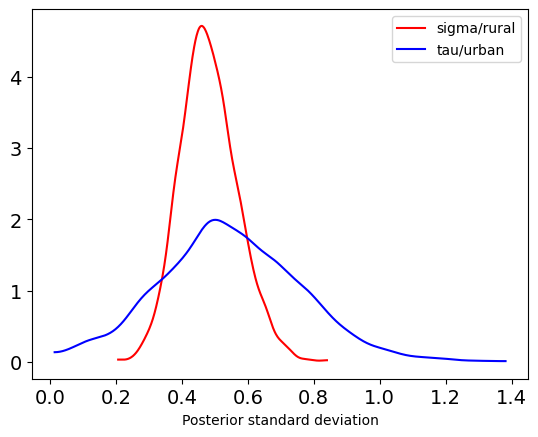

In [107]:
az.plot_dist(bangunc_trace.posterior.sigma,
             color='red',
             label='sigma/rural'
            )
az.plot_dist(bangunc_trace.posterior.tau,
             color='blue',
             label='tau/urban'
            )
plt.xlabel('Posterior standard deviation')

In [105]:
bangunc_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data